* 1 Introduction 
* 2 Load and check data
    * 2.1 load data 
    * 2.2 Outlier detectio 
    * 2.3 join train and test set 
    * check for null and missing values 
* 3 Feature analysis 
    * 3.1 Numerical values 
    * 3.2 Categorical values 
* 4 Filling missing Values 
    * 4.1 Age 
* 5 Feature engineering 
    * 5.1 Name/Title 
    * 5.2 Family Size 
    * Cabin 
    * Ticket 
* Modeling 
    * 6.1 Simple modeling 
        * 6.1.1 Cross validate models 
        * 6.1.2 Hyperparmater tunning for best models 
        * 6.1.3 Plot learning curves 
        * 6.1.4 Feature importance of the tree based classifiers 
    * 6.2 Ensemble modeling 
        * 6.2.1 Combining models 
    * Prediction 
        * Predict and Submit results 

#  1. Introduction 
## This script follows three main parts 
* Feature analysis 
* Feature engineering 
* Modeling 

In [1]:
import numpy as np 
import pandas as pd 
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline 
from collections import Counter 

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,\
GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve 

## 2.Load and check data
### 2.1 Load data

In [2]:
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier detection 

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers 

Outliers_to_drop = detect_outliers(train, 2, [ 'SibSp', 'Parch', 'Fare'])
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [4]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 2.3 joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

C:\Users\Voyager\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


### 2.4 check for null and missing values

In [7]:
# Fill empty and NaNs values with NaN
dataset.fillna(np.nan)
# check for Null values 
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [9]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# summarize data 
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3.Feature analysis
### 3.1 Numerical values

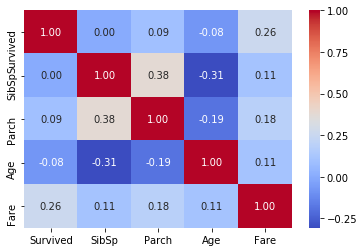

In [12]:
# correlation matrix between numerical values(SipSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

Only Fare feature seems to have a significative correlation with the survival probability 

It doesn't mean that the other feature are not useful.

Subpopulations in these features can be correlated with the survival. 

We need to explore in detail these features 

#### SibSp

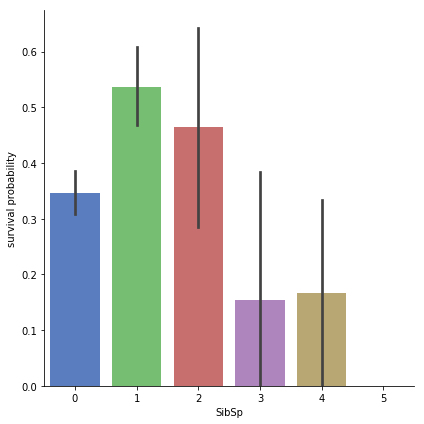

In [13]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=6, palette='muted')
# g.despine(left=True)
g.set_ylabels('survival probability')

#### Parch

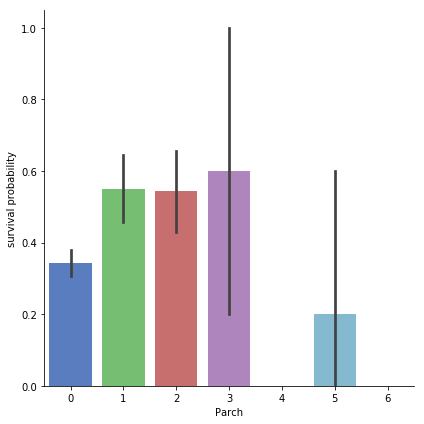

In [14]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.set_ylabels('survival probability')

#### Age

C:\Users\Voyager\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Voyager\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


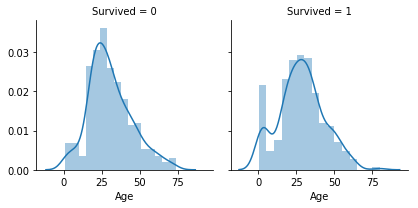

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

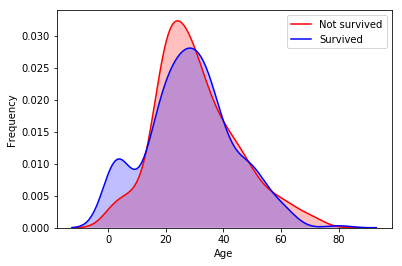

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],
               color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())],
               color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not survived', 'Survived'])

#### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

C:\Users\Voyager\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


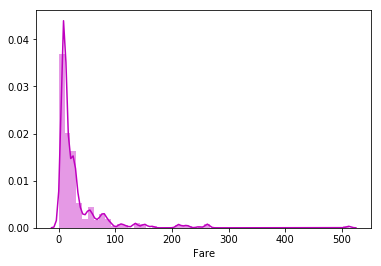

In [19]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f' % dataset['Fare'].skew())
# g = g.legend(loc='best')

In [20]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

C:\Users\Voyager\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


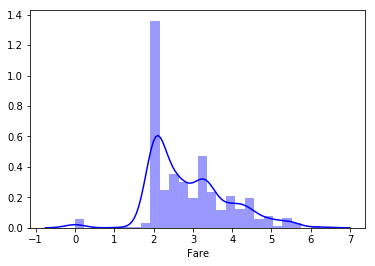

In [21]:
sns.distplot(dataset['Fare'], color='b')

### 3.2 Categorial values

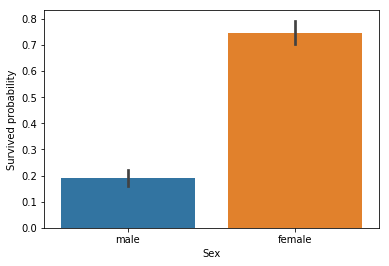

In [22]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survived probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


### Pclass

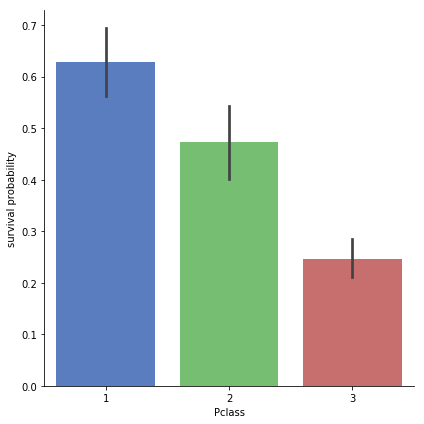

In [24]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar', size=6, palette='muted')
g.set_ylabels('survival probability')

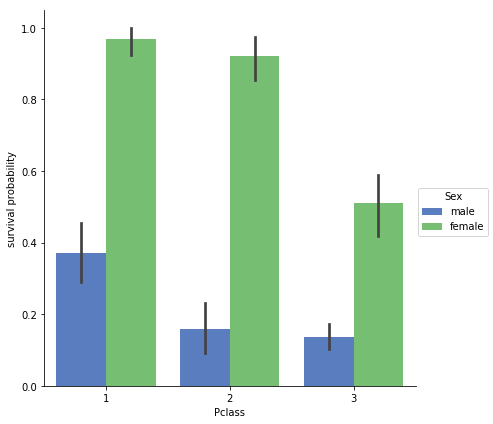

In [25]:
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=6, kind='bar', palette='muted')
g.set_ylabels('survival probability')

### Emabarked

In [26]:
dataset['Embarked'].isnull().sum()
dataset['Embarked'].fillna('S', inplace=True)

In [27]:
dataset['Embarked'].value_counts()

S    906
C    270
Q    123
Name: Embarked, dtype: int64

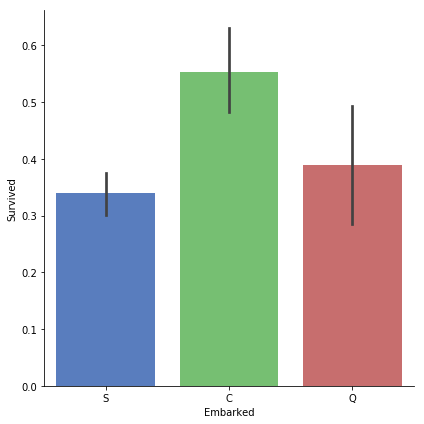

In [28]:
sns.factorplot(x='Embarked', y='Survived', data=train, size=6, kind='bar', palette='muted')

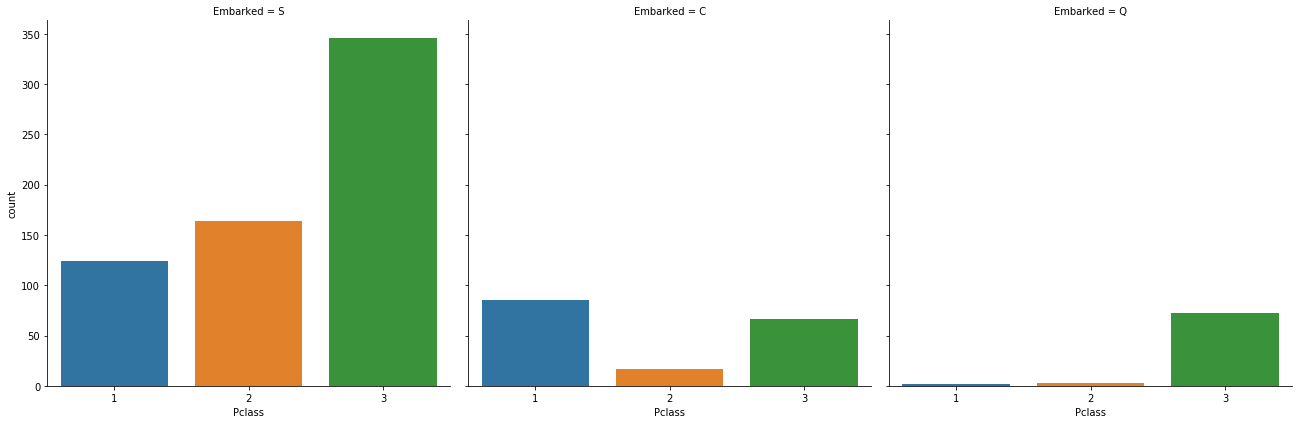

In [29]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count')

## 4.Filling missing Values

### 4.1 Age 

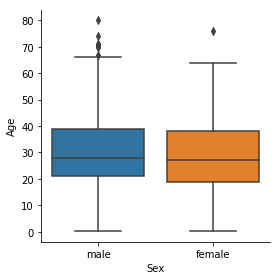

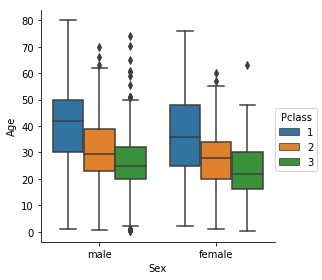

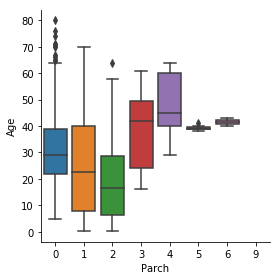

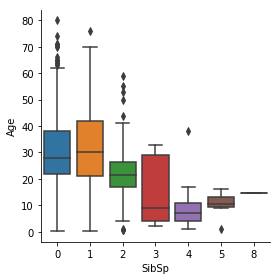

In [30]:
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

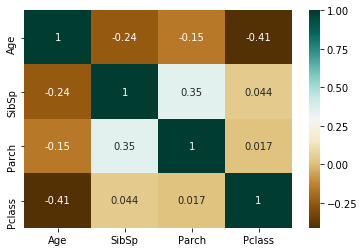

In [31]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

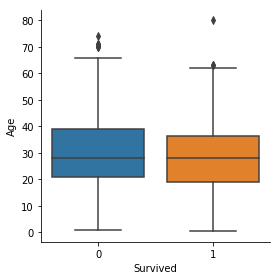

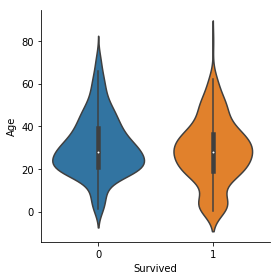

In [32]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

## 5.Feature engineering

### 5.1 Name/Title 

In [33]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)

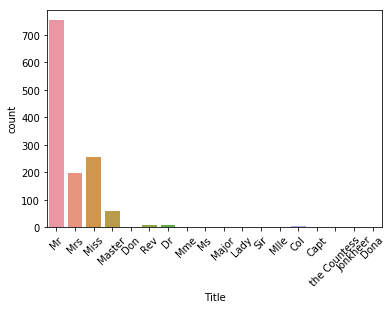

In [34]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [35]:
dataset['Title'] = dataset['Title'].replace(['Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Mrs':2, 'Mr':3, 'Rare':5})
dataset['Title'] = dataset['Title'].astype(int)

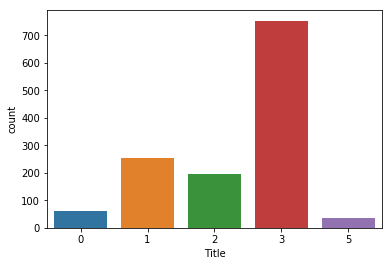

In [36]:
g = sns.countplot(dataset['Title'])

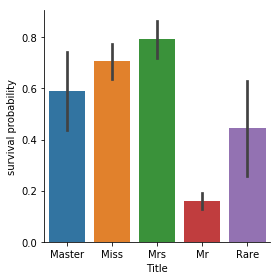

In [37]:
g = sns.factorplot(x='Title', y='Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss', 'Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [38]:
dataset[['Title', 'Survived']].groupby('Title').mean()

,Survived
Title,
0,0.589744
1,0.706215
2,0.792000
3,0.157895
5,0.444444


In [39]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

### 5.2 Family size

In [40]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1 

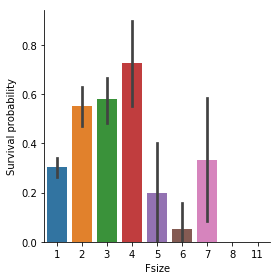

In [41]:
g = sns.factorplot(x='Fsize', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')

In [42]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

### 5.3 Cabin

In [43]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [44]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [45]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

In [46]:
dataset['Cabin'].unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

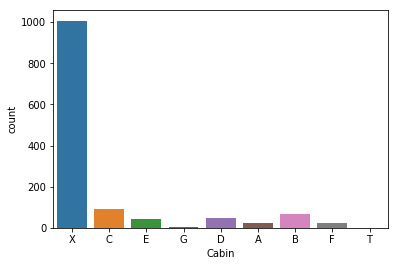

In [47]:
g = sns.countplot(dataset['Cabin'])

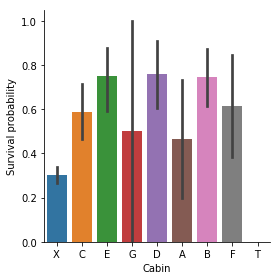

In [48]:
g = sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival probability')

In [49]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [50]:
dataset.head()

,Age,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize,Title_0,Title_1,Title_2,Title_3,Title_5,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,1.981001,0,1,3,male,1,0.0,A/5 21171,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,38.0,4.266662,0,2,1,female,1,1.0,PC 17599,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,26.0,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,35.0,3.972177,0,4,1,female,1,1.0,113803,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,35.0,2.085672,0,5,3,male,0,0.0,373450,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


In [51]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [52]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)
dataset.drop(labels=['Ticket'], axis=1, inplace=True)

In [53]:
dataset['Sex'] = dataset['Sex'].map({'male':1, 'female':0})

In [54]:
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Title_0,Title_1,Title_2,Title_3,Title_5,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,1,1,0.0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,4.266662,0,0,1,1.0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,0,0,1.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,3.972177,0,0,1,1.0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,35.0,2.085672,0,1,0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


## 填充 Age 缺失值

In [66]:
age_nan_index = dataset[dataset['Age'].isnull()].index
age_index = dataset[dataset['Age'].notnull()].index
# columns = dataset.columns
# age_index[250:]
# columns
# dataset.loc[age_nan_index, ['Age']]
print(len(age_nan_index), len(age_index))

256 1043


In [67]:
age_test = dataset.loc[age_nan_index, :]
age_test.drop(['Age'], axis=1, inplace=True)
age_train = dataset.loc[age_index, :]
age_train_y = age_train['Age']
age_train.drop(['Age'], axis=1, inplace=True)

In [68]:
age_train.drop(['Survived'], axis=1, inplace=True)
age_test.drop(['Survived'], axis=1, inplace=True)

In [69]:
print(len(age_train), len(age_test))
print(len(age_train_y))

1043 256
1043


In [70]:
age_train.head()

,Fare,Parch,Sex,SibSp,Fsize,Title_0,Title_1,Title_2,Title_3,Title_5,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Pc_1,Pc_2,Pc_3
0,1.981001,0,1,1,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,4.266662,0,0,1,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,2.070022,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,3.972177,0,0,1,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,2.085672,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [72]:
from sklearn.svm import SVR

kfold = StratifiedKFold(n_splits=10)
# # clf = RandomForestClassifier(random_state=42)
rg = SVR()
res = cross_val_score(rg, age_train, y=age_train_y)
res

array([0.26675512, 0.20770034, 0.2477424 ])

In [75]:
rg = SVR()
rg.fit(age_train, age_train_y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [76]:
age_pred = rg.predict(age_test)
# age_test.isnull().sum()
age_pred = pd.Series(age_pred, index=age_nan_index)

In [77]:
dataset.loc[age_nan_index]['Age'] = age_pred

In [78]:
copy = dataset.copy()
copy.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Title_0,Title_1,Title_2,Title_3,Title_5,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,1,1,0.0,2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,4.266662,0,0,1,1.0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,26.0,2.070022,0,0,0,1.0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,3.972177,0,0,1,1.0,2,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
4,35.0,2.085672,0,1,0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [79]:
copy.loc[age_nan_index, 'Age'] = age_pred

In [80]:
dataset['Age'] = copy['Age']

## 6.Modeling

In [313]:
copy = train.copy()
train = (copy - copy.mean()) / copy.std()

In [81]:
# Separate train and test dataset 
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

C:\Users\Voyager\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [82]:
train['Survived'] = train['Survived'].astype(int)
Y_train  = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

C:\Users\Voyager\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### 6.1 Simple modeling 

#### 6.1.1 Cross validate models 
Compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation procedure 
* SVC
* Decision 
* AdaBoost 
* RandomForest 
* Extra Trees 
* Gradient Boosting 
* Multiple layer perceprton(neural network)
* KNN 
* Logistic Regression 
* Linear Discriminant Analysis 

In [83]:
kfold = StratifiedKFold(n_splits=10)

In [84]:
# clf = GradientBoostingClassifier(random_state=random_state)
# cross_val_score(clf, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=-1)

Text(0.5,1,'Cross validation scores')

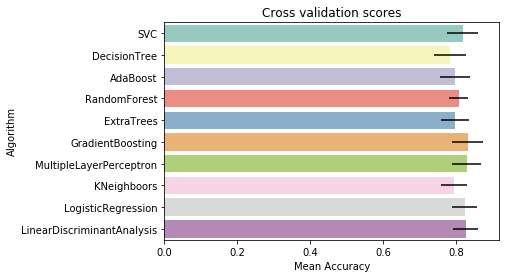

In [85]:
random_state = 42 
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means, 'CrossValerrors': cv_std,
                      'Algorithm':['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees',
                                  'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 
                                  'LogisticRegression', 'LinearDiscriminantAnalysis']})
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g.set_title('Cross validation scores')

In [86]:
cv_res

,CrossValMeans,CrossValerrors,Algorithm
0,0.818399,0.043368,SVC
1,0.783235,0.043349,DecisionTree
2,0.797995,0.041619,AdaBoost
3,0.807048,0.026803,RandomForest
4,0.796821,0.038852,ExtraTrees
5,0.832035,0.042941,GradientBoosting
6,0.829763,0.040220,MultipleLayerPerceptron
7,0.794586,0.034389,KNeighboors
8,0.824081,0.034833,LogisticRegression
9,0.826341,0.034445,LinearDiscriminantAnalysis


#### 6.1.2 Hyperparameter tunning for best models 
Grid search optimization for SVC, RandomForest, GradientBoosting, multipleLayerPerceptron, LogisticRegression 

In [87]:
# RandomForest
RFC = RandomForestClassifier()

rf_param_grid = {
    'max_depth': [None],
    'max_features': [1,3,10],
    'min_samples_split': [2,3,10],
    'min_samples_leaf':[1,3,10],
    'bootstrap': [False],
    'n_estimators': [100, 300],
    'criterion': ['gini']
}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, 
                     scoring='accuracy', n_jobs=-1, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  3.8min finished


0.8354143019296254

In [88]:
X_train['Age'] = X_train['Age'].astype(int)

In [89]:
# GradientBoosting 
GBC = GradientBoostingClassifier()
gb_param_grid = {
    'loss': ['deviance'],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth':[4,8],
    'min_samples_leaf':[100, 150],
    'max_features': [0.3, 0.1]
}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy',
                    n_jobs=-1, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.7min finished


0.8229284903518729

In [90]:
# SVC 
SVMC = SVC(probability=True)
svc_param_grid = {
    'kernel': ['rbf'],
    'gamma': [0.001, 0.01, 0.1, 1],
    'C': [1, 10, 50, 100, 200, 300, 1000]
}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold,
                     scoring='accuracy', n_jobs=-1, verbose=True)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:  1.6min finished


0.8331441543700341

#### 6.1.3 Plot learn curves

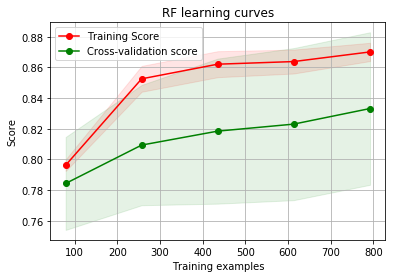

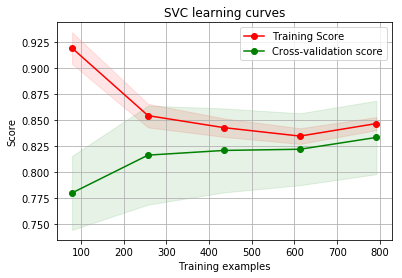

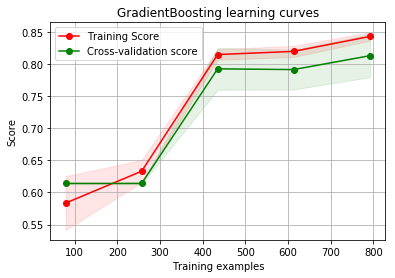

In [91]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                       n_jobs=-1, train_sizes=np.linspace(.1, 1, 5)):
    """Generate a simple plot os the best and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv,
                                                           n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, 
                    train_scores_mean+ train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt 


g = plot_learning_curve(gsRFC.best_estimator_, 'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, 'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, 'GradientBoosting learning curves', 
                       X_train, Y_train, cv=kfold)

#### 6.1.4 Feature importance of tree based classifiers

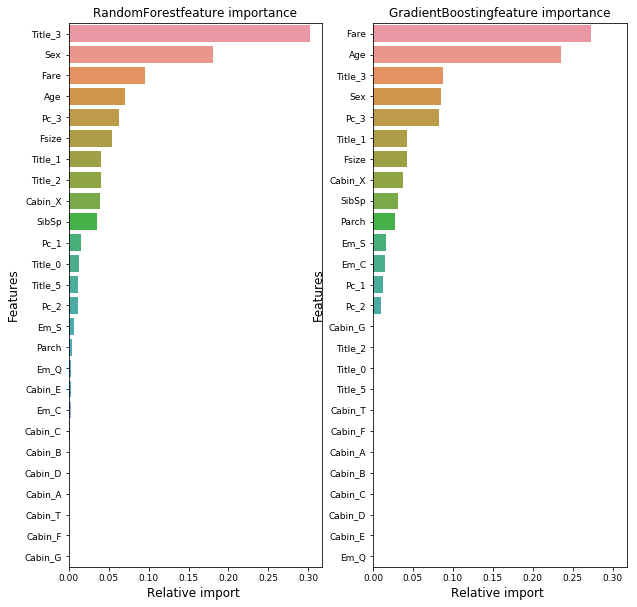

In [92]:
nrows =1; ncols = 2 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(10, 10))

name_classifiers = [('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier = 0 
for row in range(nrows):
    for col in range(ncols):
        name = name_classifiers[nclassifier][0]
        classifier = name_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], 
                        x=classifier.feature_importances_[indices][:40], 
                       orient='h', ax=axes[col])
        g.set_xlabel('Relative import ', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + 'feature importance')
        nclassifier += 1

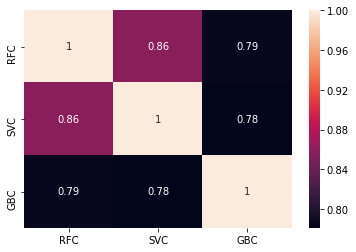

In [93]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name='SVC')
test_Survived_GBC = pd.Series(GBC_best.predict(test), name='GBC')

ensemble_results = pd.concat([test_Survived_RFC, test_Survived_SVMC, test_Survived_GBC], axis=1)
g = sns.heatmap(ensemble_results.corr(), annot=True)

## 6.2 Ensemble modeling 

### 6.2.1 combining models

In [94]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
                                       ('svc', SVMC_best),
                                       ('gbc', GBC_best)],
                                       voting='soft', n_jobs=-1)
votingC = votingC.fit(X_train, Y_train)

In [95]:
# votingC = GBC_best.fit(X_train, Y_train)

### 6.3 Prediction 

In [96]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('ensemble_ptyhon_voting_2019_11_11.csv', index=False)

C:\Users\Voyager\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
